# Overview

In this notebook, we conduct data cleaning of the merged table. 

**Author**: Oscar Javier Bastidas Jossa. 

**Email**: oscar.jossa@deusto.es.

In [2]:
import pandas as pd
import numpy as np
from utilities import Data_cleaning

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.express.colors import sample_colorscale

import math
import copy
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
df = pd.read_csv('../data/cleaned_dataset_v0.csv')
df = df.set_index('session_execution_id')


In [7]:
df_describe = df.describe()
df_describe = df_describe.drop(columns=['user_programs_user_id'])

# Get the max to correct outliers
max_description = df_describe.loc['max', :].sort_values(ascending=False)
max_series = max_description[~max_description.keys().str.contains('_reps_')]
max_series = max_series[~max_series.keys().str.contains('_time_')]
max_series

Knee push-up                               275.0
Rest                                       259.0
Sprint                                     102.0
Pull-up                                    102.0
Skipping                                    68.0
Paleo sit-up                                41.0
Burpee                                      36.0
Squat                                       32.0
Push-up                                     32.0
V sit-up                                    32.0
Skipping knees & elbows                     29.0
Plank balance                               27.0
Dips                                        25.0
1 leg dead lift (left)                      24.0
Free thruster                               24.0
Isometric bridge                            24.0
Toes to bar                                 24.0
1 leg dead lift (right)                     24.0
Lunges (left)                               24.0
Lunges (right)                              24.0
Side to side squat  

In [6]:
df.loc[df['Rest'] == 259.0]

,session_executions_updated_at,user_programs_user_id,1 leg bridge (left),1 leg bridge (left)_reps_1,1 leg bridge (left)_reps_10,1 leg bridge (left)_reps_11,1 leg bridge (left)_reps_12,1 leg bridge (left)_reps_13,1 leg bridge (left)_reps_14,1 leg bridge (left)_reps_15,1 leg bridge (left)_reps_16,1 leg bridge (left)_reps_17,1 leg bridge (left)_reps_2,1 leg bridge (left)_reps_3,1 leg bridge (left)_reps_4,1 leg bridge (left)_reps_5,1 leg bridge (left)_reps_6,1 leg bridge (left)_reps_7,1 leg bridge (left)_reps_8,1 leg bridge (left)_reps_9,1 leg bridge (left)_time_1,1 leg bridge (left)_time_10,1 leg bridge (left)_time_11,1 leg bridge (left)_time_12,1 leg bridge (left)_time_13,1 leg bridge (left)_time_14,1 leg bridge (left)_time_15,1 leg bridge (left)_time_16,1 leg bridge (left)_time_17,1 leg bridge (left)_time_2,1 leg bridge (left)_time_3,1 leg bridge (left)_time_4,1 leg bridge (left)_time_5,1 leg bridge (left)_time_6,1 leg bridge (left)_time_7,1 leg bridge (left)_time_8,1 leg bridge (left)_time_9,1 leg bridge (right),1 leg bridge (right)_reps_1,1 leg bridge (right)_reps_10,1 leg bridge (right)_reps_11,1 leg bridge (right)_reps_12,1 leg bridge (right)_reps_13,1 leg bridge (right)_reps_14,1 leg bridge (right)_reps_15,1 leg bridge (right)_reps_16,1 leg bridge (right)_reps_17,1 leg bridge (right)_reps_2,1 leg bridge (right)_reps_3,1 leg bridge (right)_reps_4,1 leg bridge (right)_reps_5,1 leg bridge (right)_reps_6,1 leg bridge (right)_reps_7,1 leg bridge (right)_reps_8,1 leg bridge (right)_reps_9,1 leg bridge (right)_time_1,1 leg bridge (right)_time_10,1 leg bridge (right)_time_11,1 leg bridge (right)_time_12,1 leg bridge (right)_time_13,1 leg bridge (right)_time_14,1 leg bridge (right)_time_15,1 leg bridge (right)_time_16,1 leg bridge (right)_time_17,1 leg bridge (right)_time_2,1 leg bridge (right)_time_3,1 leg bridge (right)_time_4,1 leg bridge (right)_time_5,1 leg bridge (right)_time_6,1 leg bridge (right)_time_7,1 leg bridge (right)_time_8,1 leg bridge (right)_time_9,1 leg dead lift (left),1 leg dead lift (left)_reps_1,1 leg dead lift (left)_reps_10,1 leg dead lift (left)_reps_11,1 leg dead lift (left)_reps_12,1 leg dead lift (left)_reps_13,1 leg dead lift (left)_reps_14,1 leg dead lift (left)_reps_15,1 leg dead lift (left)_reps_2,1 leg dead lift (left)_reps_3,1 leg dead lift (left)_reps_4,1 leg dead lift (left)_reps_5,1 leg dead lift (left)_reps_6,1 leg dead lift (left)_reps_7,1 leg dead lift (left)_reps_8,1 leg dead lift (left)_reps_9,1 leg dead lift (left)_time_1,1 leg dead lift (left)_time_10,1 leg dead lift (left)_time_11,1 leg dead lift (left)_time_12,1 leg dead lift (left)_time_13,1 leg dead lift (left)_time_14,1 leg dead lift (left)_time_15,1 leg dead lift (left)_time_2,1 leg dead lift (left)_time_3,1 leg dead lift (left)_time_4,1 leg dead lift (left)_time_5,1 leg dead lift (left)_time_6,1 leg dead lift (left)_time_7,1 leg dead lift (left)_time_8,1 leg dead lift (left)_time_9,1 leg dead lift (right),1 leg dead lift (right)_reps_1,1 leg dead lift (right)_reps_10,1 leg dead lift (right)_reps_11,1 leg dead lift (right)_reps_12,1 leg dead lift (right)_reps_13,1 leg dead lift (right)_reps_14,1 leg dead lift (right)_reps_15,1 leg dead lift (right)_reps_2,1 leg dead lift (right)_reps_3,1 leg dead lift (right)_reps_4,1 leg dead lift (right)_reps_5,1 leg dead lift (right)_reps_6,1 leg dead lift (right)_reps_7,1 leg dead lift (right)_reps_8,1 leg dead lift (right)_reps_9,1 leg dead lift (right)_time_1,1 leg dead lift (right)_time_10,1 leg dead lift (right)_time_11,1 leg dead lift (right)_time_12,1 leg dead lift (right)_time_13,1 leg dead lift (right)_time_14,1 leg dead lift (right)_time_15,1 leg dead lift (right)_time_2,1 leg dead lift (right)_time_3,1 leg dead lift (right)_time_4,1 leg dead lift (right)_time_5,1 leg dead lift (right)_time_6,1 leg dead lift (right)_time_7,1 leg dead lift (right)_time_8,1 leg dead lift (right)_time_9,1 leg dead lift 1with KB (right),1 leg dead lift 1with KB (right)_reps_1,1 leg dead lift 1with KB (righ

In [134]:
# df_describe.loc['max', :].sort_values(ascending=False)[0:1000]
top_30_exercises = df.drop(columns=['session_executions_updated_at', 'user_programs_user_id', 'date']).astype(bool).sum(axis=0)
top_30_exercises = top_30_exercises[~top_30_exercises.keys().str.contains('_reps_')]
top_30_exercises = top_30_exercises[~top_30_exercises.keys().str.contains('_time_')]
top_30_exercises = top_30_exercises.sort_values(ascending=False)[1:30] # Ommiting Rest that is the zero value

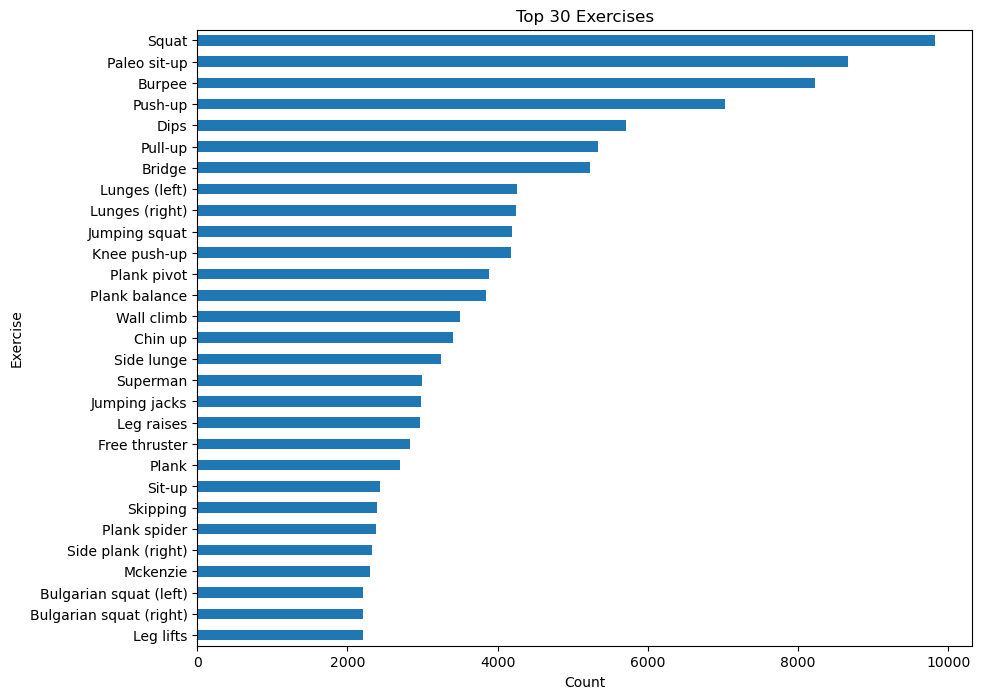

In [56]:
# Assuming top_30_exercises is your Series containing exercise names and their counts
ax = top_30_exercises.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))

# Set title and labels
ax.set_title('Top 30 Exercises')
ax.set_xlabel('Count')
ax.set_ylabel('Exercise')

# Show the plot
plt.show()